In [63]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# MNIST

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
x, y = mnist['data'], mnist['target']

print(f'The shape of x is {x.shape} and the shape of y is {y.shape}')

The shape of x is (70000, 784) and the shape of y is (70000,)


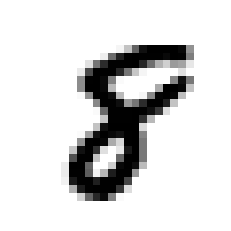

In [4]:
some_digit = x[777]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y[777]

'8'

In [6]:
y = y.astype(np.uint8)

In [7]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([False])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [11]:
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

## Confusion Matrix

In [12]:
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

In [13]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

## Precision and Recall

In [18]:
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
f1 = f1_score(y_train_5,y_train_pred)

print(f'The precision of the model is {round(precision, 4) * 100}% and the recall of the model is {round(recall, 4) * 100}%.')
print(f'The F1 score of the model is {round(f1, 4) * 100}%.')

The precision of the model is 83.71% and the recall of the model is 65.12%.
The F1 score of the model is 73.25%.


## Precision/Recall Trade-off

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-6167.89937769])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [27]:
# Plotting the Precision vs recall curve

y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=5, method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):

  plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
  plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
  plt.show()

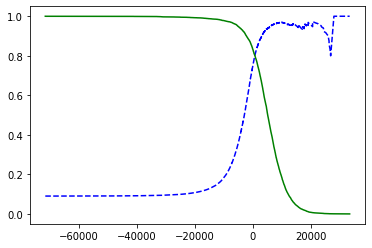

In [29]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [30]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

print(f'The shape of the original training set was {y_train_5.shape}, and the new training set aiming for the 90% precision is {y_train_pred_90.shape}')

The shape of the original training set was (60000,), and the new training set aiming for the 90% precision is (60000,)


In [34]:
precision_90 = precision_score(y_train_5, y_train_pred_90)
recall_90 = recall_score(y_train_5, y_train_pred_90)
f1_90 = f1_score(y_train_5, y_train_pred_90)

print('The results of this model are:')
print(f'\tPrecision: {round(precision_90, 4) * 100}%')
print(f'\tRecall: {round(recall_90, 4) * 100}%')
print(f'\tF1: {round(f1_90, 4) * 100}%')

The results of this model are:
	Precision: 90.02%
	Recall: 65.89%
	F1: 76.09%


## The ROC Curve

In [36]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [37]:
def plot_roc_curve(frp, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.show()

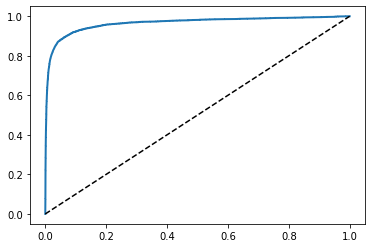

In [38]:
plot_roc_curve(fpr, tpr, 'ROC Curve')

In [40]:
roc_auc_score(y_train_5, y_scores)

0.9648211175804801

In [43]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method='predict_proba')

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

ValueError: ignored

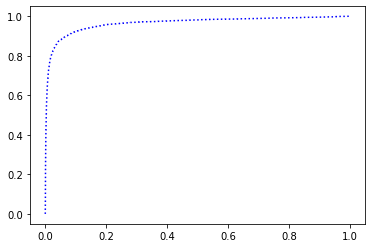

In [44]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

# Multiclass Classification

In [46]:
svm_clf = SVC()
svm_clf.fit(x_train, y_train)
svm_clf.predict([some_digit])

array([8], dtype=uint8)

In [48]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(x_train, y_train)

NameError: ignored

In [49]:
ovr_clf.predict([some_digit])

array([8], dtype=uint8)

In [50]:
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digit])

array([8], dtype=uint8)

In [55]:
cross_val_score(sgd_clf, x_train, y_train, cv=5, scoring='accuracy')

array([0.88083333, 0.88325   , 0.88116667, 0.86625   , 0.8875    ])

In [56]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=5, scoring='accuracy')

array([0.89733333, 0.88725   , 0.89583333, 0.89233333, 0.90516667])

# Error Analysis

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=5)
conf_mx = confusion_matrix(y_train, y_train_pred)

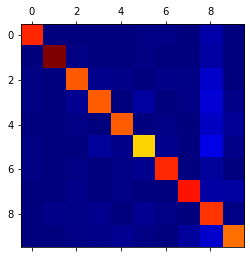

In [61]:
plt.matshow(conf_mx, cmap=plt.cm.jet)
plt.show()

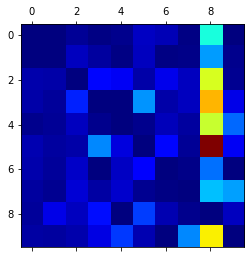

In [62]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.jet)
plt.show()

# Multilabel Classification

In [64]:
y_train_large = (y_train >= 7)
y_train_odd = ((y_train % 2) == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [65]:
knn_clf.predict([some_digit])

array([[ True, False]])

In [66]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

# Multioutput Classification

In [67]:
noise = np.randint(0, 100, (len(x_train), 784))
x_train_mod = x_train + noise

noise = np.random.randint(0, 100, (len(x_test), 784))
x_test_mod = x_test + noise

y_train_mod = x_train
y_test_mod = x_test

AttributeError: ignored

In [ ]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predit([x_test_mod[some_index]])
plot_digit(clean_digit)

# Exercises

1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

2. Write a function that can shift an MNIST image in any direction (left, right, up,
or down) by one pixel. Then, for each image in the training set, create four shif‐
ted copies (one per direction) and add them to the training set. Finally, train your
best model on this expanded training set and measure its accuracy on the test set.
You should observe that your model performs even better now! This technique of
artificially growing the training set is called data augmentation or training set
expansion.


3. Tackle the Titanic dataset. A great place to start is on Kaggle.

4. Build a spam classifier (a more challenging exercise):
- Download examples of spam and ham from Apache SpamAssassin’s public
datasets.
- Unzip the datasets and familiarize yourself with the data format.
- Split the datasets into a training set and a test set.
- Write a data preparation pipeline to convert each email into a feature vector.
Your preparation pipeline should transform an email into a (sparse) vector that
indicates the presence or absence of each possible word. For example, if all
emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email
“Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1]
(meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is
present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of
each word.
You may want to add hyperparameters to your preparation pipeline to control
whether or not to strip off email headers, convert each email to lowercase,
remove punctuation, replace all URLs with “URL,” replace all numbers with
“NUMBER,” or even perform stemming (i.e., trim off word endings; there are
Python libraries available to do this).
Finally, try out several classifiers and see if you can build a great spam classi‐
fier, with both high recall and high precision.
